# Changing settings when solving PyBaMM models

[This](https://github.com/pybamm-team/PyBaMM/blob/develop/examples/notebooks/models/SPM.ipynb) example notebook showed how to run an SPM battery model, using the default parameters, discretisation and solvers that were defined for that particular model. Naturally we would like the ability to alter these options on a case by case basis, and this notebook gives an example of how to do this, again using the SPM model. In this notebook we explicitly handle all the stages of setting up, processing and solving the model in order to explain them in detail. However, it is often simpler in practice to use the `Simulation` class, which handles many of the stages automatically, as shown [here](https://github.com/pybamm-team/PyBaMM/blob/develop/examples/notebooks/simulation-class.ipynb).


### Table of Contents
1. Default SPM model
1. Changing the parameters
1. Changing the discretisation
1. Changing the solver

## The default SPM model  <a name="default"></a>

Below is the code to define and run the default SPM model included in PyBaMM (if this is unfamiliar to you, please see [this](./models/SPM.ipynb) notebook for more details)

In [17]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import numpy as np
import os
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')

# create the model
model = pybamm.lithium_ion.SPM()

# set the default model geometry
geometry = model.default_geometry

# set the default model parameters
param = model.default_parameter_values

# set the parameters for the model and the geometry
param.process_model(model)
param.process_geometry(geometry)

# mesh the domains
mesh = pybamm.Mesh(geometry, model.default_submesh_types, model.default_var_pts)

# discretise the model equations
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model)

# Solve the model at the given time points
solver = model.default_solver
n = 100
t_eval = np.linspace(0, 3600, n)
solution = solver.solve(model, t_eval)

You should consider upgrading via the '/home/mrobins/git/PyBaMM/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


To verify the solution, we can look at a plot of the Voltage over time

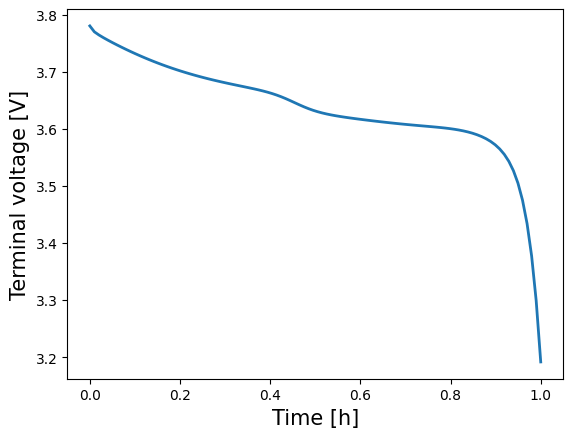

In [18]:
time = solution["Time [h]"].entries
voltage = solution["Voltage [V]"].entries
plt.plot(time, voltage, lw=2, label=model.name)
plt.xlabel("Time [h]", fontsize=15)
plt.ylabel("Voltage [V]", fontsize=15)
plt.show()

## Changing the model parameters <a name="parameters"></a>

The parameters are defined using the [`pybamm.ParameterValues`](https://pybamm.readthedocs.io/en/latest/source/api/parameters/parameter_values.html) class, which takes either a python dictionary or CSV file with the mapping between parameter names and values.

First lets have a look at the default parameters that are included with the SPM model:

In [19]:
model.default_parameter_values.items

<bound method ParameterValues.items of {'Thermodynamic factor': 1.0,
 'Ambient temperature [K]': 298.15,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': 0.4,
 'Cell cooling surface area [m2]': 0.0569,
 'Cell volume [m3]': 7.8e-06,
 'Current function [A]': 0.680616,
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'Edge heat transfer coefficient [W.m-2.K-1]': 0.3,
 'Electrode height [m]': 0.137,
 'Electrode width [m]': 0.207,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_Capiglia1999 at 0x7fb36b261160>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diffusivity_Capiglia1999 at 0x7fb36b2611f0>,
 'Initial concentration in electrolyte [mol.m-3]': 1000.0,
 'Initial concentration in negative electrode [mol.m-3]': 19986.609595075,
 'Initial concentration in positive electrode [mol.m-3]': 30730.7554385565,
 'Initial inner SEI thickness [m]': 2.5e-09,
 'Initial outer SEI thickn

In [20]:
format_str = '{:<75}  {:>20}'
print(format_str.format('PARAMETER', 'VALUE'))
print("-"*97)
for key, value in model.default_parameter_values.items():
    try:
        print(format_str.format(key, value))
    except TypeError:
        print(format_str.format(key, value.__str__()))

PARAMETER                                                                                   VALUE
-------------------------------------------------------------------------------------------------
Ratio of lithium moles to SEI moles                                                           2.0
Inner SEI reaction proportion                                                                 0.5
Inner SEI partial molar volume [m3.mol-1]                                               9.585e-05
Outer SEI partial molar volume [m3.mol-1]                                               9.585e-05
SEI reaction exchange current density [A.m-2]                                             1.5e-07
SEI resistivity [Ohm.m]                                                                  200000.0
Outer SEI solvent diffusivity [m2.s-1]                                       2.5000000000000002e-22
Bulk solvent concentration [mol.m-3]                                                       2636.0
Inner SEI open-cir

Most of the parameters in this list have numerical values. Some have string values, that point to particular python functions within PyBaMM. These denote parameters that vary over time and/or space, in a manner defined by the given python function. For the moment we will ignore these, and focus on altering one of the numerical parameters.

The class [`pybamm.ParameterValues`](https://pybamm.readthedocs.io/en/latest/source/api/parameters/parameter_values.html) acts like the normal python `dict` data structure, so you can read or write individual parameters accordingly:

In [21]:
variable = "Current function [A]"
old_value = param[variable]
param[variable] = 1.4
new_value = param[variable]
print(variable,'was',old_value)
print(variable,'now is',param[variable])

Current function [A] was 0.680616
Current function [A] now is 1.4


In order to compare solutions with different parameter values, parameters must be changed to `InputParameter` objects, whose value can then be specified when solving. For example, we can compare the Voltage calculated using both the old and new current values.

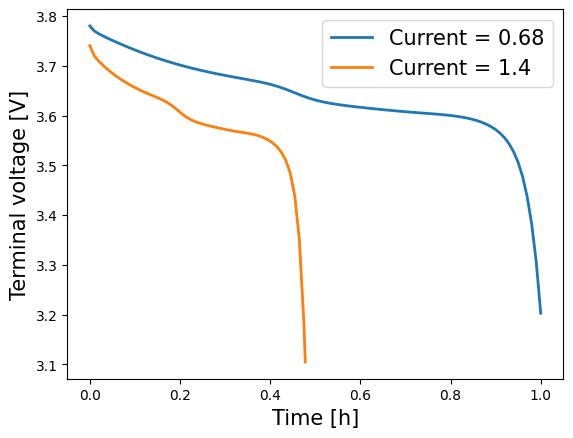

In [22]:
# Set up
model = pybamm.lithium_ion.SPM()
solver = model.default_solver
param["Current function [A]"] = "[input]"
param.process_model(model)
disc.process_model(model)

# Solution with current = 0.68
old_solution = solver.solve(model, t_eval, inputs={"Current function [A]": 0.68})
old_time = old_solution["Time [h]"].entries
old_voltage = old_solution["Voltage [V]"].entries

# Solution with current = 1.4
new_solution = solver.solve(model, t_eval, inputs={"Current function [A]": 1.4})
new_time = new_solution["Time [h]"].entries
new_voltage = new_solution["Voltage [V]"].entries

plt.plot(old_time, old_voltage, lw=2, label="Current = 0.68")
plt.plot(new_time, new_voltage, lw=2, label="Current = 1.4")
plt.xlabel("Time [h]", fontsize=15)
plt.ylabel("Voltage [V]", fontsize=15)
plt.legend(fontsize=15)
plt.show()

Note that there is a small number of parameters for which this is not possible, since the discretisation depends on them (for example, *Negative electrode thickness*). In this case you would need to remesh the geometry as the relative length of the electrodes would have altered. This would in turn require you to re-discretise the model equations.

## Changing the discretisation <a name="discretisation"></a>

The chosen spatial discretisation method to use for each domain is passed into the [`pybamm.Discretisation`](https://pybamm.readthedocs.io/en/latest/source/api/spatial_methods/discretisation.html) class as one of its arguments. The default spatial methods for the SPM class are given as:


In [23]:
print(format_str.format('DOMAIN', 'DISCRETISED BY'))
print("-"*82)
for key, value in model.default_spatial_methods.items():
    print(format_str.format(key, value.__class__.__name__))

DOMAIN                                                                             DISCRETISED BY
----------------------------------------------------------------------------------
macroscale                                                                           FiniteVolume
negative particle                                                                    FiniteVolume
positive particle                                                                    FiniteVolume
negative primary particle                                                            FiniteVolume
positive primary particle                                                            FiniteVolume
negative secondary particle                                                          FiniteVolume
positive secondary particle                                                          FiniteVolume
negative particle size                                                               FiniteVolume
positive particle size             

To change the discretisation for a particular domain, you can update the spatial methods `dict` with the new discretiation class  that you wish to use, for example:

In [24]:
spatial_methods = model.default_spatial_methods
spatial_methods["negative particle"] = pybamm.SpectralVolume()

You can also update the submeshes (meshes used for each domain) in a similar way. We'll generate a spectral mesh to use with our spectral volume method in the negative particle

In [25]:
submesh_types = model.default_submesh_types
submesh_types["negative particle"] = pybamm.MeshGenerator(pybamm.SpectralVolume1DSubMesh)

Now that we have set the new discretisation method, we can proceed to re-discretise and then solve the model. Note that in this case we need to regenerate the model using `pybamm.lithium_ion.SPM`, as the original model information was lost when we discretised it [above](#default). 

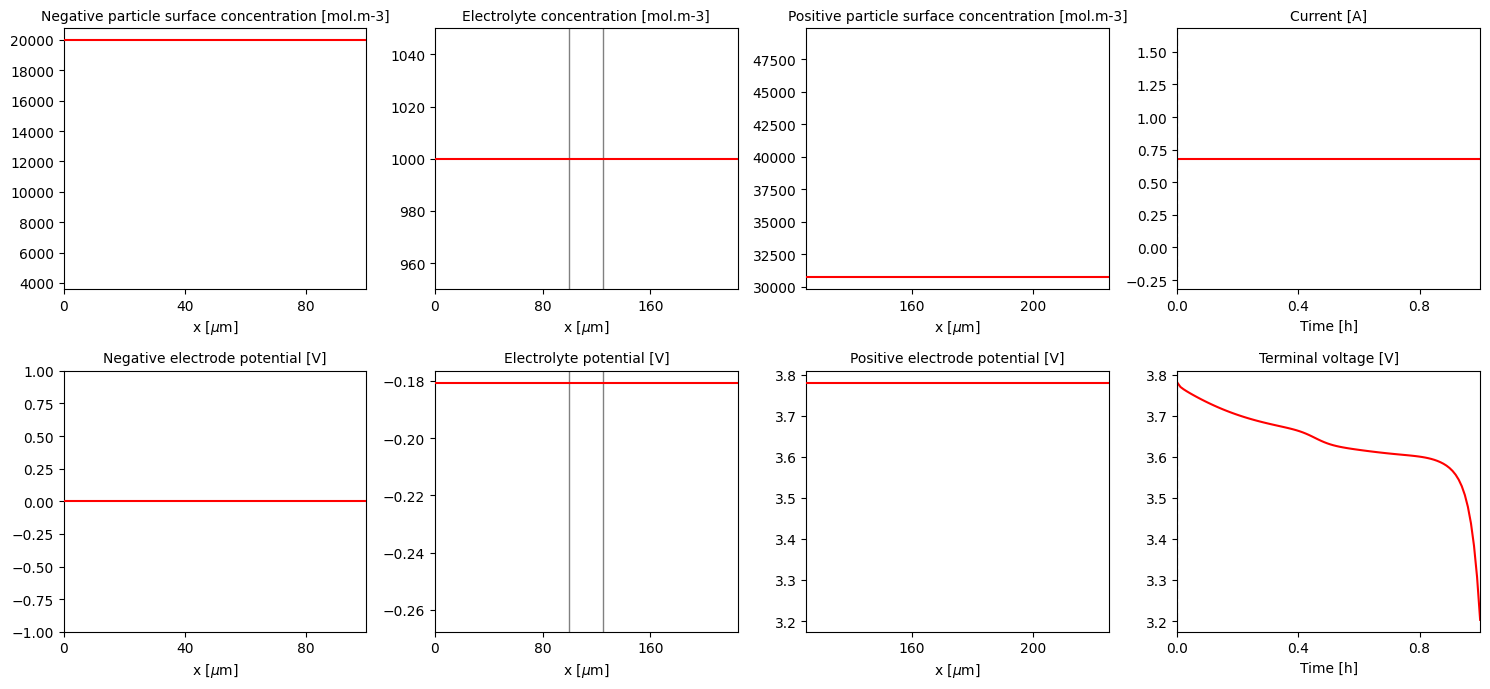

In [26]:
# re-generate the model and set parameters (with fixed current function this time)
model = pybamm.lithium_ion.SPM()
solver = model.default_solver
param["Current function [A]"] = 0.68
param.process_model(model)

# re-discretise the model with the new mesh...
mesh = pybamm.Mesh(geometry, submesh_types, model.default_var_pts)
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model)

# ... and finally solve it
solution = solver.solve(model, t_eval)
pybamm.QuickPlot(solution).plot(0)

## Changing the solver <a name="solver"></a>

Which method you use to integrate the discretised model in time can also be changed. PyBaMM has a number of different solvers available, all of which are described in the [documentation](https://pybamm.readthedocs.io/en/latest/source/api/solvers/index.html).


In [27]:
print('Default solver for SPM model:',type(model.default_solver).__name__)

Default solver for SPM model: CasadiSolver


To change this, simply create a new solver using one of the available classes and use it to solve your discretised model

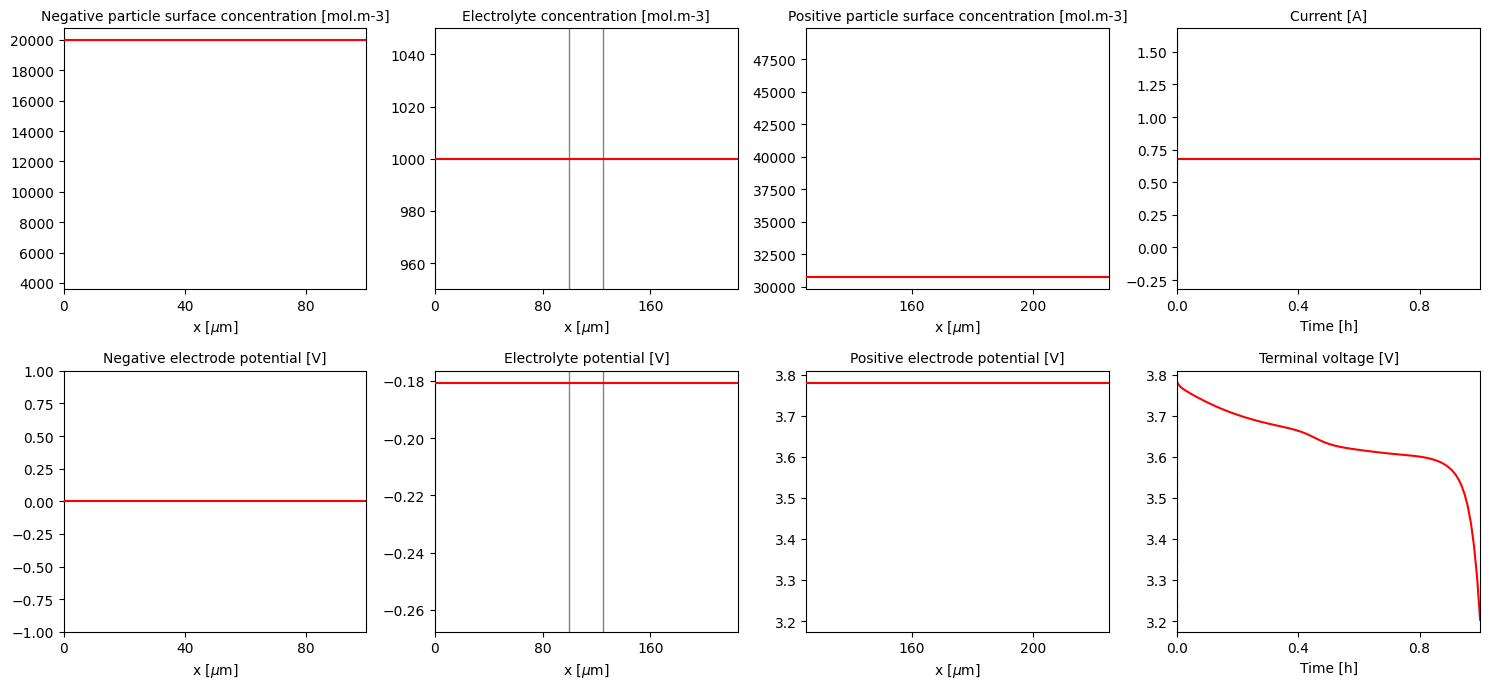

In [28]:
new_solver = pybamm.ScipySolver()
new_solution = new_solver.solve(model, t_eval)
pybamm.QuickPlot(new_solution).plot(0)

## References

The relevant papers for this notebook are:

In [29]:
pybamm.print_citations()

[1] Weilong Ai, Ludwig Kraft, Johannes Sturm, Andreas Jossen, and Billy Wu. Electrochemical thermal-mechanical modelling of stress inhomogeneity in lithium-ion pouch cells. Journal of The Electrochemical Society, 167(1):013512, 2019. doi:10.1149/2.0122001JES.
[2] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[3] Rutooj Deshpande, Mark Verbrugge, Yang-Tse Cheng, John Wang, and Ping Liu. Battery cycle life prediction with coupled chemical degradation and fatigue mechanics. Journal of the Electrochemical Society, 159(10):A1730, 2012. doi:10.1149/2.049210jes.
[4] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(782